# Αναγνώριση Προτύπων - Μηχανική Μάθηση 3η Εργασία
## Στειροπούλου Ευαγγελία 
### 1115201800186

# FeedForward Neural Network

In [218]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install -U scikit-learn

import os
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
# from google.colab import drive
# drive.mount('/content/gdrive')

## Load Data (mfccs)

In [219]:
path = os.getcwd()
print(path)

#path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/mfccs'
test_data_path = path + '/data/music_genre_data_di/test/mfccs'
validation_data_path = path + '/data/music_genre_data_di/val/mfccs'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

# Μετατροπή των labels σε ακέραιους αριθμούς (0, 1, 2, 3)
classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

# Δημιουργία των Tensor αντικειμένων από τα numpy arrays
train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Εμφάνιση των διαστάσεων των Tensor
print(train_dataset.tensors[0].shape)
print(train_dataset.tensors[1].shape)
print(val_dataset.tensors[0].shape)
print(val_dataset.tensors[1].shape)
print(test_dataset.tensors[0].shape)
print(test_dataset.tensors[1].shape)


/home/eva/Documents/machine_learning/Project3
torch.Size([3200, 26])
torch.Size([3200])
torch.Size([800, 26])
torch.Size([800])
torch.Size([1376, 26])
torch.Size([1376])


## Build Neural Network

In [220]:
# # if we want to utilize the GPU (if available), we need to assign the model to the correct device
# if torch.cuda.is_available():
#   device="cuda"
# else:
#     device="cpu"

# print ("device=",device)

class FullyConnectedNeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(FullyConnectedNeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26 , 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cpu"
model = FullyConnectedNeuralNetwork().to(device)
print(model)

# X = torch.rand(1, 26, device = device)  ##dummy data στην  GPU

# # this call uses the forward function of the model along with some background operations.
# # Notice that we do not explicitly call forward. This is handled by PyTorch.
# log = model(X)

FullyConnectedNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


## Set Neural Network training function

In [221]:
def train_network(model, optimizer, dataloader, loss_function, num_epochs):
    size = len(dataloader.dataset)

    for epoch in range(num_epochs):
        loss = 0.0
        print("Epoch: ", epoch+1)
        for batch_idx, (data, targets) in enumerate(dataloader):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = loss_function(outputs, targets)
            
            # Clear the gradients and compute new gradients (backward pass)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # Update the weights

            print(f"loss: {loss:>7f}  [{batch_idx:>5d}/{size:>5d}]")
            
    print('Training finished.')
    return model

## Set evaluation function

In [222]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate_model(model, dataloader, loss_function):
    model.eval()  # Put the model in evaluation mode
    device = next(model.parameters()).device

    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()

            all_predictions.extend(predictions.argmax(1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().detach().numpy())


    avg_loss = total_loss / len(dataloader)

    # Calculate F1 score, accuracy, and confusion matrix
    f1_score_macro = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    confusion_mat = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1_score_macro, accuracy, confusion_mat

## Train Neural Network

In [223]:
import torch.optim as optim
# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro, accuracy, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_mat)
print(device)

# Return the trained model
trained_model = model

Epoch:  1
loss: 1.414604  [    0/ 3200]
loss: 1.402424  [    1/ 3200]
loss: 1.338547  [    2/ 3200]
loss: 1.343698  [    3/ 3200]
loss: 1.405591  [    4/ 3200]
loss: 1.389248  [    5/ 3200]
loss: 1.425171  [    6/ 3200]
loss: 1.421166  [    7/ 3200]
loss: 1.312324  [    8/ 3200]
loss: 1.387834  [    9/ 3200]
loss: 1.373621  [   10/ 3200]
loss: 1.438251  [   11/ 3200]
loss: 1.398564  [   12/ 3200]
loss: 1.408786  [   13/ 3200]
loss: 1.344333  [   14/ 3200]
loss: 1.428947  [   15/ 3200]
loss: 1.384700  [   16/ 3200]
loss: 1.420650  [   17/ 3200]
loss: 1.375800  [   18/ 3200]
loss: 1.394507  [   19/ 3200]
loss: 1.371830  [   20/ 3200]
loss: 1.359450  [   21/ 3200]
loss: 1.418412  [   22/ 3200]
loss: 1.408723  [   23/ 3200]
loss: 1.366140  [   24/ 3200]
loss: 1.410359  [   25/ 3200]
loss: 1.366331  [   26/ 3200]
loss: 1.385406  [   27/ 3200]
loss: 1.383281  [   28/ 3200]
loss: 1.394567  [   29/ 3200]
loss: 1.363650  [   30/ 3200]
loss: 1.362927  [   31/ 3200]
loss: 1.401277  [   32/ 3200]


## Train Network with GPU

In [224]:
import torch.optim as optim
# if we want to utilize the GPU (if available), we need to assign the model to the correct device

if torch.cuda.is_available():
    device="cuda"
    print("GPU available")
else:
    device="cpu"

print ("device=",device)
model = FullyConnectedNeuralNetwork().to(device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro, accuracy, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_mat)

# Return the trained model
trained_model = model

device= cpu
Epoch:  1
loss: 1.449543  [    0/ 3200]
loss: 1.410747  [    1/ 3200]
loss: 1.386439  [    2/ 3200]
loss: 1.409988  [    3/ 3200]
loss: 1.467227  [    4/ 3200]
loss: 1.432923  [    5/ 3200]
loss: 1.436219  [    6/ 3200]
loss: 1.357206  [    7/ 3200]
loss: 1.398784  [    8/ 3200]
loss: 1.426616  [    9/ 3200]
loss: 1.414331  [   10/ 3200]
loss: 1.428527  [   11/ 3200]
loss: 1.355962  [   12/ 3200]
loss: 1.433728  [   13/ 3200]
loss: 1.420559  [   14/ 3200]
loss: 1.492343  [   15/ 3200]
loss: 1.427404  [   16/ 3200]
loss: 1.334879  [   17/ 3200]
loss: 1.436475  [   18/ 3200]
loss: 1.439841  [   19/ 3200]
loss: 1.303013  [   20/ 3200]
loss: 1.410639  [   21/ 3200]
loss: 1.401489  [   22/ 3200]
loss: 1.416447  [   23/ 3200]
loss: 1.412828  [   24/ 3200]
loss: 1.374321  [   25/ 3200]
loss: 1.395023  [   26/ 3200]
loss: 1.354107  [   27/ 3200]
loss: 1.353079  [   28/ 3200]
loss: 1.438228  [   29/ 3200]
loss: 1.419839  [   30/ 3200]
loss: 1.377177  [   31/ 3200]
loss: 1.382166  [ 

## Choose model

In [225]:
def train_and_evaluate(model, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, num_epochs):
    best_model = None
    best_f1 = 0.0

    # Training loop
    for epoch in range(num_epochs):
        # Train the model
        train_network(model, optimizer, train_dataloader, loss_function, 1)

        # Evaluate the model on the validation set
        val_loss, val_f1, val_accuracy, val_confusion_mat = evaluate_model(model, val_dataloader, loss_function)

        print(f"Epoch: {epoch+1}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation F1: {val_f1:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print("Validation Confusion Matrix:")
        print(val_confusion_mat)

        # Save the model with the best F1 score on the validation set
        if val_f1 > best_f1:
            best_model = model
            best_f1 = val_f1

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mat = evaluate_model(best_model, test_dataloader, loss_function)

    print("Best Model Performance on Test Set:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Test Confusion Matrix:")
    print(test_confusion_mat)

    return best_model, test_loss, test_f1, test_accuracy, test_confusion_mat


In [226]:
best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs
)


Epoch:  1
loss: 0.652477  [    0/ 3200]
loss: 1.010451  [    1/ 3200]
loss: 0.926135  [    2/ 3200]
loss: 0.895955  [    3/ 3200]
loss: 0.997836  [    4/ 3200]
loss: 0.903912  [    5/ 3200]
loss: 1.161251  [    6/ 3200]
loss: 1.120892  [    7/ 3200]
loss: 1.030235  [    8/ 3200]
loss: 0.936125  [    9/ 3200]
loss: 0.920190  [   10/ 3200]
loss: 1.148975  [   11/ 3200]
loss: 0.677553  [   12/ 3200]
loss: 0.850483  [   13/ 3200]
loss: 0.969023  [   14/ 3200]
loss: 0.803753  [   15/ 3200]
loss: 0.750909  [   16/ 3200]
loss: 0.803521  [   17/ 3200]
loss: 0.966160  [   18/ 3200]
loss: 0.557710  [   19/ 3200]
loss: 0.944551  [   20/ 3200]
loss: 0.827979  [   21/ 3200]
loss: 0.922811  [   22/ 3200]
loss: 0.922725  [   23/ 3200]
loss: 0.849937  [   24/ 3200]
loss: 0.853879  [   25/ 3200]
loss: 0.887372  [   26/ 3200]
loss: 1.131519  [   27/ 3200]
loss: 1.039113  [   28/ 3200]
loss: 0.700667  [   29/ 3200]
loss: 0.831723  [   30/ 3200]
loss: 0.831254  [   31/ 3200]
loss: 1.251496  [   32/ 3200]


# Convolutional Neural Network

In [227]:
path = os.getcwd()
print(path)

#path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/melgrams'
test_data_path = path + '/data/music_genre_data_di/test/melgrams'
validation_data_path = path + '/data/music_genre_data_di/val/melgrams'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

# Μετατροπή των labels σε ακέραιους αριθμούς (0, 1, 2, 3)
classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

# Δημιουργία των Tensor αντικειμένων από τα numpy arrays
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Εμφάνιση των διαστάσεων των Tensor
print(train_dataset.tensors[0].shape)
print(train_dataset.tensors[1].shape)
print(val_dataset.tensors[0].shape)
print(val_dataset.tensors[1].shape)
print(test_dataset.tensors[0].shape)
print(test_dataset.tensors[1].shape)


/home/eva/Documents/machine_learning/Project3
torch.Size([3200, 21, 128])
torch.Size([3200])
torch.Size([800, 21, 128])
torch.Size([800])
torch.Size([1376, 21, 128])
torch.Size([1376])


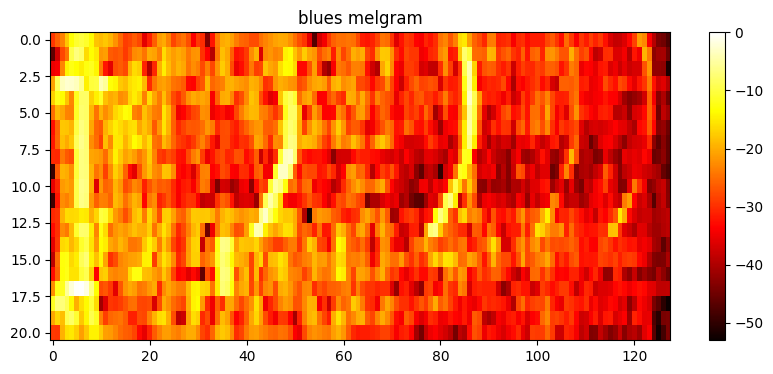

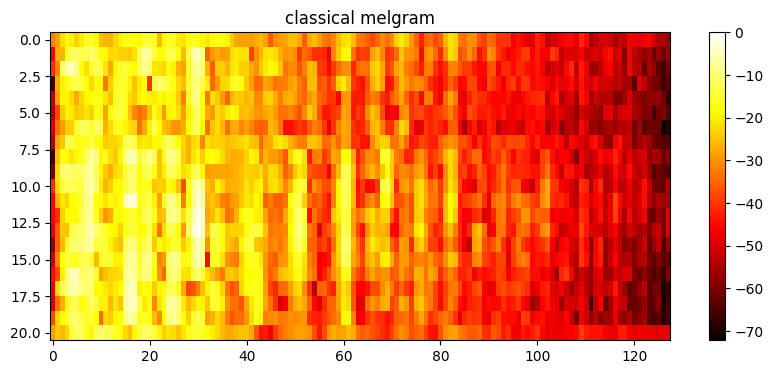

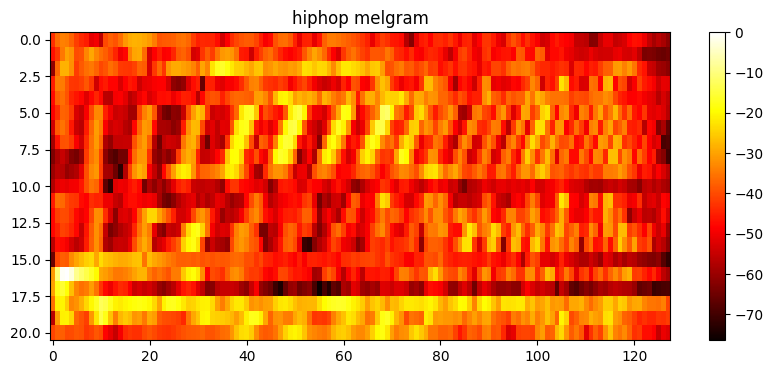

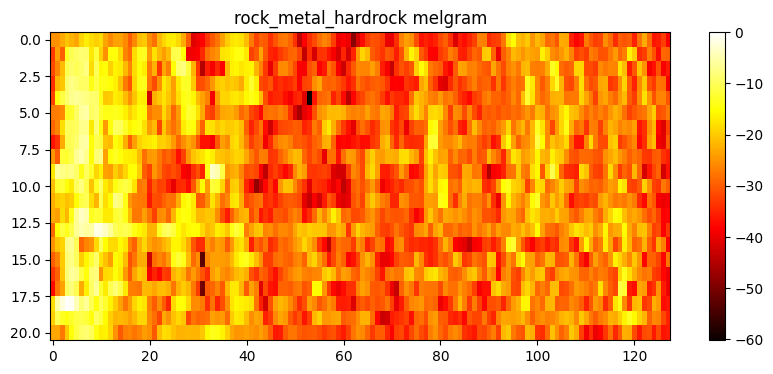

In [228]:
import random

def visualize_melgram(melgram, class_name):
    plt.figure(figsize=(10, 4))
    plt.imshow(melgram, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(class_name + ' melgram')
    plt.show()

# Function to plot a random melgram from each class
def plot_random_melgram_from_each_class(dataset, class_labels, class_names):
    classes = np.unique(class_labels)
    for class_label in classes:
        indices = np.where(class_labels == class_label)[0]
        # Select a random index
        random_index = random.choice(indices)
        melgram, label = dataset[random_index]
        class_name = class_names[class_label]  # Get the class name corresponding to the class label
        visualize_melgram(melgram, class_name)

# Retrieve the class names from the class_to_idx dictionary
class_names = [class_label for class_label, class_index in class_to_idx.items()]

# Plot a random melgram from each class in the training dataset
plot_random_melgram_from_each_class(train_dataset, y_train, class_names)
